In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random_graph
import itertools
import collections
import pandas as pd
from pandas.plotting import parallel_coordinates
from matplotlib import rc
import functools
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.sparse as sparse
rc('text', usetex=True)
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch, Wedge
from matplotlib.collections import PatchCollection

sns.set(font='serif', style='white')

In [7]:
with open('tmp/nsyot_fullnaiveseen.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetrace = json.load(f)coords = random_graph.generate_sorted_grid_coords(16)

In [10]:
coords = random_graph.generate_sorted_grid_coords(16)

In [3]:
CSS = """
.output {
    flex-direction: row;
}
"""
from IPython.display import display, HTML
HTML('<style>{}</style>'.format(CSS))

In [4]:
def pie_marker(r1=0.9,size1=10):
    # first define the ratios
    #r1 = 0.9       # 20%
    r2 = r1 + 0.4  # 40%
    # define some sizes of the scatter marker
    #size1= 10
    #sizes = np.array([60, 80, 120])
    # calculate the points of the first pie marker
    #
    # these are just the origin (0,0) +
    # some points on a circle cos,sin
    x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
    y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 20)).tolist()
    xy1 = np.column_stack([x, y])
    s1 = np.abs(xy1).max()
    return {'s':s1**2 *size1,'marker':(xy1,0)}
    #fig, ax = plt.subplots()
    #ax.scatter(range(3), range(3), marker=(xy1, 0),
    #       s=s1 ** 2 * sizes, facecolor='blue')
    #ax.scatter(range(3), range(3), marker=(xy2, 0),
    #       s=s2 ** 2 * sizes, facecolor='green')
    #ax.scatter(range(3), range(3), marker=(xy3, 0),
    #       s=s3 ** 2 * sizes, facecolor='red')

    #plt.show()
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
def heatplot3d(statusdata,batterydata, coords,ax, vmin=0,vmax=1,z=0):
    """
    data: {'S0':p0,'S1':p1...} where p1..pn is the probability of being in that state
    """
    xs =set([x for x,y in coords])
    ys = set([y for x,y in coords])
    top_coords = list(itertools.product(xs, [max(ys)]))
    top_extensions = [[(x,y),(x,y+5)] for x,y in top_coords]
    bottom_coords = list(itertools.product(xs, [min(ys)]))
    bottom_extensions = [[(x,y),(x,y-5)] for x,y in bottom_coords]
    right_coords= list(itertools.product([max(xs)], ys))
    left_coords = list(itertools.product([min(xs)], ys)) 
    left_extensions = [[(x,y),(x-5,y)] for x,y in left_coords]
    right_extensions = [[(x,y),(x+5,y)] for x,y in right_coords]
    verticals = [list(itertools.product([x],ys)) for x in xs]
    s=800
    horizs = [list(itertools.product(xs,[y])) for y in ys]
    name_to_num = lambda s:int(s[1::])
    stringifier = lambda s: str(s) if len(str(s))==2 else ' '+str(s)        
    cmap=plt.get_cmap("Greys")
    #our_colors = functools.partial(get_color, cmap)
    our_colors = {0:'#252525',
             1:'#ffffff',
             2:'#cb181d',
                 3:'#ffffff'}
    contrast = {0:'#ffffff',
             1:'#252525',
             2:'#252525',
                 3:'#252525'}
    #solars = [500*ancillary['S'+str(idx)] for idx, v in enumerate(coords)]
    zs = [z for _ in coords]
    
    #ax.scatter([x for x,y in coords],[y for x,y in coords],s=solars,
    #           edgecolor='#525252', linewidth=1)
        
    for line in horizs+verticals+top_extensions+bottom_extensions+left_extensions+right_extensions:
        ax.plot([x for x,y in line],[y for x,y in line],[z for _ in line], color ='#d9d9d9',
                zorder =-1, linestyle ='--')
    p = Circle(coords[0], 3,alpha=1,zorder=-100)
    #ax.add_patch(p)
    #art3d.pathpatch_2d_to_3d(p, z=z, zdir="z")
    #size_of_groups=[0.9,0.1]
    pie_params = pie_marker(size1=1800)
    
    for idx,(x,y) in enumerate(coords):
        sensorname='S'+str(idx)
        val = statusdata[sensorname]
        battery = batterydata[sensorname]
        battery_fudger = lambda x: 0.95 if x>0.95 else (0.02 if x<0.02 else x)
        offset = battery_fudger(battery)
        color = our_colors[val]
        pie_params = pie_marker(size1=1800,r1=offset)
        ax.scatter([x], [y],[z],marker=pie_params['marker'],s=pie_params['s'],zorder=9,color='#252525')
        ax.scatter([x], [y],[z],s=0.8*pie_params['s'], color='#ffffff',zorder=8)
        ax.text(x,y,z,str(idx), color=contrast[val],horizontalalignment='center'
                ,verticalalignment='center', fontsize=20,zorder=100)
        if val == 1:
            ax.scatter([x],[y],[z],color=color, edgecolor='#525252',hatch='///', linewidth=1,s=s, alpha=1,zorder=10)
        else:
            ax.scatter([x],[y],[z],color=color, edgecolor='#525252', linewidth=1,s=s, alpha=1,zorder=10)
    statuses = [statusdata['S'+str(idx)] for idx,v in enumerate(coords)]
    #print(statuses)
    #circ=[]
    #circ.append(Circle (coords[0], 3))
    #coll=PatchCollection(circ, zorder=-1)
    #ax.add_collection(coll)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax.set_zlim([0,1])
    #ax_cbar = fig.add_axes([1, 0.2, 0.1, 0.6])
    
    #ax_cbar = fig.add_axes([0.2,0,0.6,0.1])
    #cbar = plt.colorbar(sc, ax = ax_cbar, orientation='horizontal', fraction=1,label='Proportion of time active',
    #                    ticks=[0,0.2,0.4,0.6,0.8,1])
    #cbar.outline.set_visible(False)
    #cbar.ax.tick_params(direction='out', length=2, width=0.5, colors='#525252',
    #          grid_color='#525252', grid_alpha=0.5)
    #ax_cbar.axes.get_xaxis().set_visible(False)
    #ax_cbar.axes.get_yaxis().set_visible(False)
    #ax_cbar.set_yticklabels([])
    return ax


In [8]:
run =4
startday=43
periods=8
duration=5
select = [startday*periods,(startday+duration)*periods]
thedata = statetrace['data'][run][select[0]:select[1]]

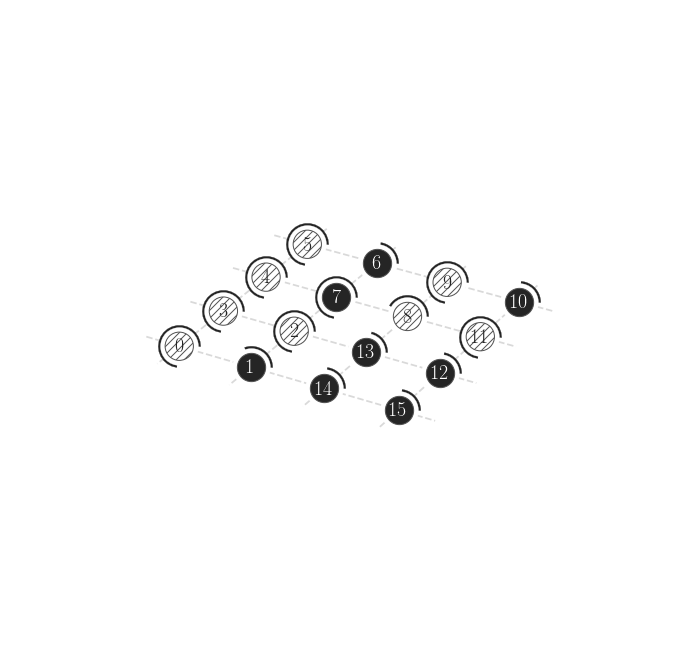

In [12]:
#fig, ax = plt.subplots(1)
#fig.set_size_inches(4,4)
#heatplot(avg_solar, coords, ax,fig,vmin=0.2,vmax=0.4)
#sns.despine(left=True, bottom=True)
from mpl_toolkits.mplot3d import Axes3D
for tslice in range(16,17):
    battdata = {k:v[1]/10 for k,v in thedata[tslice].items()}
    statuscalcer = lambda status, battery: status if battery>0 else 3
    statusdata = {k:statuscalcer(v[0], battdata[k]) for k,v in thedata[tslice].items()}
    fig = plt.figure()
    fig.set_size_inches(12,12)
    ax = fig.add_subplot(111, projection='3d')
    #for i in [-2]:
    ax= heatplot3d(statusdata,battdata,coords, ax,z=0)
    ax.set_axis_off()
    fig.savefig('3deno_{}.png'.format(tslice), dpi=600, transparent=True)
#sns.despine(left=True, bottom=True)
#fig2.savefig('heatplot.png')

In [ ]:
battdata

In [ ]:
contrast_text(hex_to_rgb('#253494'))

In [ ]:
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4)
idx1,idx2 = 3,4
freq_count = count_on_frequency(datae[idx1:idx2])
avg_solar = avg_ancillary(ancillarye[idx1:idx2])
heatplot(avg_solar, coords, ax,fig,vmin=0.2,vmax=0.4)
sns.despine(left=True, bottom=True)
fig2,ax2 = plt.subplots(1)
fig2.set_size_inches(4,4)
heatplot(freq_count, coords, ax2, fig2)
sns.despine(left=True, bottom=True)

In [ ]:
def correlation_solar(onavg, solar_avg):
    keys = ['S'+str(idx) for idx in range(16)]
    d1 = np.array([onavg[k] for k in keys])
    d2 = np.array([solar_avg[k] for k in keys])
    d10 = d1-np.mean(d1)
    d20 = d2-np.mean(d2)
    return np.corrcoef(d10,d20)[1,0]
corrs = np.zeros((15,15))
for idx1, idx2 in itertools.product([i for i in range(15)], repeat=2):
    freq_count = count_on_frequency(datae[idx1:idx1+1])
    avg_solar = avg_ancillary(ancillarye[idx2:idx2+1])
    corrs[idx1,idx2] = correlation_solar(freq_count,avg_solar)
_ =sns.heatmap(corrs)

In [ ]:
def find_pairwise_correlations(states, relative=False):
    states = pd.DataFrame([collections.OrderedDict(i) for i in unroll(data)])
    total_states = len(states)
    keys = list(states.columns)
    dfs = {k:states[states[k]==1] for k in keys}
    if relative:
        totals = {k:v.mean(axis=0) for k,v in dfs.items()}
    else:
        totals = {k:v.sum(axis=0)/total_states for k,v in dfs.items()} 
    heat_array = np.asarray([v.values for k,v in 
                             sorted(totals.items(),
                                    key=lambda i:int(i[0][1::]))])
    return heat_array

In [ ]:
heat_array = find_pairwise_correlations(data, relative=False)
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4.5)
ax = sns.heatmap(heat_array,ax=ax,vmin=0,vmax=0.5,
                 cbar_kws = dict(use_gridspec=False,location="top",label='Correlation'))

In [ ]:
transition_sparse = transition_matrix(data)

In [ ]:
transition_sparse[[s for s in set(transition_sparse)][0]]

In [ ]:
def is_irreducible(sparsemat):
    check_irreducibility = np.linalg.matrix_power(sparsemat.todense(), 100000)
    return np.min(check_irreducibility)>0
def dict_to_sparsemat(d):
    all_states = set([k for k in d]+[v for k,vs in d.items() for v in vs])
    n= len(all_states)
    hashmap ={state:idx for idx, state in enumerate(all_states)}
    mtx = sparse.dok_matrix((n, n), dtype=np.float64)
    for state, destinations in d.items():
        state_idx = hashmap[state]
        for destination,p in destinations.items():
            destination_idx = hashmap[destination]
            mtx[state_idx, destination_idx] = p
    return hashmap, mtx
def stationary_distribution(sparsemat):
    vals, vecs = sparse.linalg.eigs(sparsemat.T, k=6)
    ind = vals.argsort()
    largest = np.array(vecs[:, ind[-1]]).flatten().real
    norm = float(largest.sum())
    probabilities = largest/norm
    largest_3_idx = probabilities.argsort()[::-1][0:10]
    return dict(zip(largest_3_idx, probabilities[largest_3_idx]))
def analyse(d):
    lookup, sparsemat = dict_to_sparsemat(transition_sparse)
    inverted_lookup = {v:k for k,v in lookup.items()}
    pagerank = stationary_distribution(sparsemat)
    res = {inverted_lookup[idx]:p for idx, p in pagerank.items()}
    most_common = [dict(json.loads(i)) for i in res]
    return most_common

In [ ]:
lookup, sparsemat = dict_to_sparsemat(transition_sparse)

In [ ]:
res = analyse(transition_sparse)

In [ ]:
fig, axarr = plt.subplots(3, 2)
fig.set_size_inches(3.5,6)
for idx, ax in enumerate(itertools.chain(*axarr)):
    plot(res[idx], coords, ax, idx)
sns.despine(left=True, bottom=True)
fig.tight_layout()
fig.savefig('threecommon.png', dpi=600)
#sns.despine()

In [ ]:
def find_lookup_mode(moderank):
    copied = json.loads(json.dumps(moderank))
    f = copied.get('F')
    del copied['F']
    ordered = sorted([(k,int(v)) for k,v in copied.items()], key = lambda i:i[0])
    return json.dumps(ordered), f
def crosscheck_pagerank(dict_data, res):
    lookup = dict([find_lookup_mode(i) for i in dict_data])
    fmatted = sorted([(k,int(v)) for k,v in res.items()], key = lambda i:i[0])
    return lookup[json.dumps(fmatted)]

In [ ]:
crosscheck_pagerank(dict_data,res[5])

In [ ]:
import copy,itertools
#with open('tmp/arcyn_5000_episodes_month.json') as f:
#    statetracelearned = json.load(f)
with open('tmp/cuysq_6000_preserve3b_shortlearnedseen.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetracelearned = json.load(f)
def num_changes(d):
    any_changes =  {k:v for k,v in d.items() if v}
    return len(any_changes)
def plotthreeoptions(statetrace):
    deepcolor='#cb181d'
    idlecolor='#f05f40'
    activecolor='#253494'
    run =4
    startday=43
    periods=8
    duration=3
    select = [startday*periods,(startday+duration)*periods]
    fulldata = statetrace['data'][run]
    data = statetrace['data'][run]#[0:select[1]+16]
    xs = list(range(len(fulldata)))#[0:select[1]+16]
    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(3.5,8)
    #fig, ax1 = plt.subplots(1)
    #fig.set_size_inches(8,4)
    def bit(i):
        res = 0 if int(i) in [1,2] else 1 
        return res
    for sensor in ['S'+str(i) for i in range(16)]:#['S0','S1','S2','S3']:
        sensordata = [i[sensor] for i in data]
        pairs = list(zip(sensordata,sensordata[1::]))
        battdata = [{'srcx':xs[idx],'status':src[0], 'src':src[1], 'dst':dst[1]}
                    for idx, (src,dst) in enumerate(pairs)]
        deepbattdata = copy.deepcopy(battdata)
        idlebattdata = copy.deepcopy(battdata)   
        onbattdata = copy.deepcopy(battdata)   
        for d in deepbattdata:
            if d['status'] in [0,1]:
                d['src'],d['dst'] = (np.nan, np.nan)
        for d in onbattdata:
            if d['status'] in [1,2]:
                d['src'],d['dst'] = (np.nan, np.nan)
        for d in idlebattdata:
            if d['status'] in [0,2]:
                d['src'],d['dst'] = (np.nan, np.nan)
        def unroller(d):
            return [(d['srcx'], d['src']), (d['srcx']+1, d['dst'])]
        def prepare(series):
            return list(itertools.chain(*[unroller(d) for d in series]))
        label1 = 'Active\nnodes'
        label2 = 'Idle\nnodes'
        label3 = 'Deep sleep\nnodes'
        ax1.plot([x for x,y in prepare(onbattdata)],[y for x,y in prepare(onbattdata)],
                 linestyle='--',linewidth=1, color =activecolor,marker='o'
                 , markersize=3, alpha=0.7, label=label1 if sensor=='S0' else '')
        ax1.plot([x for x,y in prepare(idlebattdata)],[y for x,y in prepare(idlebattdata)],
                 linestyle='-',linewidth=1, color =idlecolor,marker='o'
                 , markersize=3, alpha=0.7,label=label2 if sensor=='S0' else '')
        ax1.plot([x for x,y in prepare(deepbattdata)],[y for x,y in prepare(deepbattdata)],
                 linestyle=':',linewidth=1, color =deepcolor,marker='o'
                 , markersize=3, alpha=0.7,label=label3 if sensor=='S0' else '')
    ticks = [i for i in range(select[0], select[1]) if i%8==0]
    xlabels = [int((i/8)%30) for i in ticks]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(xlabels)
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(xlabels)
    ax1.set_xlim([select[0], select[1]])
    ax2.set_xlim([select[0], select[1]])
    count_on = lambda de: sum([v[0]==0 and v[1]!=0 for k,v in de.items()])#and v[1]!=0
    count_deep = lambda de: sum([v[0]==2 for k,v in de.items()])
    count_idle = lambda de: sum([v[0]==1 and v[1]!=0 for k,v in de.items()])
    #ax2b = ax2.twinx()
    counts = [count_on(d) for d in data]
    deep_count = [count_deep(d) for d in data]
    idle_count = [count_idle(d) for d in data]
    
    ax2.plot(xs, counts, color = activecolor,drawstyle='steps-post', 
             linestyle= '-',markersize=2.5, marker='o', linewidth=1.25, label='\# Active\n  nodes')
    
    ax2.plot(xs, idle_count, color = idlecolor,drawstyle='steps-post', 
             linestyle= '-',markersize=2.5, marker='o', linewidth=1.25, label='\# Idle\n nodes')
    ax2.plot(xs, deep_count, color = deepcolor,drawstyle='steps-post', 
             linestyle= '-',markersize=2.5, marker='o', linewidth=1.25, label='\# Deep sleep\n  nodes')
    ax2.set_ylabel('\# of nodes')
    ax2.set_xlabel('Day')
    #ax1.set_xlabel('Hours')
    ax1.set_ylabel(r'Fraction of $B_{max}$')
    #sns.despine()
    ax1.set_ylim([0,11])
    ax2.set_ylim([0,10])
    ax1.set_yticks([i for i in range(0,11)])
    ax1.set_yticklabels([i/10 for i in ax1.get_yticks()])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    #ax1.legend(loc='upper left', ncol=2)
    ax1.legend(bbox_to_anchor=(0,1),ncol=3, columnspacing=0.1)
    #ax2.legend(bbox_to_anchor=(1.2,1.05),ncol=3, columnspacing=0)
    #ax2.legend(bbox_to_anchor=(1.1,0.5))#loc='lower right')
    #fig.tight_layout()
    return fig,ax1, ax2
fig,ax1,ax2 = plotthreeoptions(statetrace)
#fig.tight_layout()
fig.savefig('timeseries_investigation.png',dpi=600)

In [ ]:
with open('tmp/wwvux_three_naive_seen.json') as f:
    statetracenaive = json.load(f)
f, a1,a2 = plotthreeoptions(statetracenaive)

In [1]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3.5,8)
"""with open('tmp/cuysq_6000_preserve3b_shortlearnedseen.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetrace = json.load(f)
run=3
startday = 38
periods = 8#in three hours 8 periods make a full day
duration =4#days
"""
with open('tmp/cuysq_6000_preserve3b_shortlearnedseen.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetrace = json.load(f)
run =4
startday=43
periods=8
duration=5
select = [startday*periods,(startday+duration)*periods]
fulldata = statetrace['data'][run]
data = statetrace['data'][run]#[0:select[1]+16]
#print([i['S15'][0] for i in data[select[0]:select[1]]])
xs = list(range(len(fulldata)))#[0:select[1]+16]
flag0,flag1,flag2,flag3 = True, True,True,True
for i in range(16):
    #sensor = data['S'+str(idx)]
    ys = [i]*len(xs)
    for idxf, state in enumerate(data[select[0]:select[1]]):
        idx= select[0]+idxf                        
        sensorstate = state['S'+str(i)]
        #print(sensorstate)
        status = sensorstate[0]
        battery = sensorstate[1]
        bit = 1 if battery>0 else 0
        if status == 0 and battery>0:
            label ='Active' if flag0 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#253494', linewidth=3,label=label)#battery/2)
            flag0 =False
        if status == 1 and battery>0:
            label ='Standby' if flag1 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#f05f40', linewidth=3*bit, linestyle='-',label=label)#battery/2)
            flag1 = False
        if status == 2 and battery>0:
            label = 'Deep sleep' if flag2 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#cb181d', linewidth=3*bit, linestyle=':',label=label)#battery/2)
            flag2 = False
        if battery == 0:
            label ='Dead' if flag3 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#d9d9d9', linewidth=2,linestyle=':',label=label)#battery/2)
            flag3=False
sns.despine()
yticks = [i for i in range(select[0], select[1]) if i%8==0]
for y in yticks:
    ax.plot([0,16],[y,y], linestyle='--', color='#525252', alpha=0.2)
ylabels = [int((i/8)%30) for i in yticks]
_ =ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylabel('Day')
xticks = [int(i) for i in range(16)]
_ =ax.set_xticks(xticks)
_ = ax.set_xlabel('Sensor \#')
_=ax.legend(bbox_to_anchor=(1,1.05),ncol=2)
#ax.axvline(x=0)
fig.savefig('temporaldetail.png',dpi=600)
#ax.set_ylim()
#['S12','S10','S9','S15','S11','S14','S7','S13']

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/james/continuous/venv/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-524e77cdd630>", line 1, in <module>
    fig, ax = plt.subplots(1)
NameError: name 'plt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/james/continuous/venv/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/james/continuous/venv/lib/python3.4/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/james/c

NameError: name 'plt' is not defined

In [ ]:
cmap=plt.get_cmap("Greys")
our_colors = functools.partial(get_color, cmap)

In [ ]:
our_colors(0)